In [24]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from natorch.utils.data import train_test_split, one_hot
from natorch.utils.metrics import accuracy
from natorch.nn.modules.losses import CrossEntropyLoss
from natorch.optim import SGD

from natorch.nn.models.lenet5.model import LeNet5

### Import Dataset

In [25]:
data_path = '../../../../../data/MNIST/MNIST.csv'
data = pd.read_csv(data_path)
data.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data Pre-processing

**Spliting and Normalization**

In [26]:
X = data.iloc[:, 1:].to_numpy()
y = data.iloc[:, 0].to_numpy()
X = X/255.0
X.shape, y.shape

((42000, 784), (42000,))

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
x_train.shape, y_train.shape

((33600, 784), (33600,))

In [28]:
x_train = x_train.reshape(33600, 1, 28, 28)
pad_width = (
    (0, 0),  
    (0, 0),   
    (2, 2), 
    (2, 2) 
)

x_train = np.pad(x_train, pad_width=pad_width, mode='constant', constant_values=0)
x_train.shape

(33600, 1, 32, 32)

In [29]:
y_train = one_hot(y_train, num_classes = 10)
y_train.shape

(33600, 10)

### Define model

In [30]:
model = LeNet5()

In [31]:
def fit(x_train: np.ndarray, y_train: np.ndarray, epochs: int = 10, lr: float = 1e-3, batch_size: int = 32) -> None:

        N = x_train.shape[0]
        loss_fn = CrossEntropyLoss()
        optimizer = SGD(model.net._parameter(), lr=lr)
        
        for epoch in range(1, epochs+1):
            perm = np.random.permutation(N)
            epoch_loss = 0.0
            correct = 0.0

            for i in tqdm(range(0, N, batch_size), desc=f"Epoch {epoch}"):
                optimizer.zero_grad()
                idx = perm[i : i + batch_size]
                xb = x_train[idx]
                yb = y_train[idx]

                # Forward
                preds = model.forward(xb)
                loss = loss_fn.forward(preds, yb)
                epoch_loss += loss * xb.shape[0]
                
                batch_acc = accuracy(preds, yb)       # returns fraction correct in [0,1]
                correct += batch_acc * xb.shape[0]   # un-scale to count   
                
                # Backward
                grad_loss = loss_fn.backward(1.0)
                model.backward(grad_loss)

                # Update
                optimizer.step()
        
            epoch_loss /= N
            epoch_acc = correct / N
            print(f"Epoch {epoch}/{epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")

In [32]:
fit(x_train, y_train, epochs = 10, lr = 0.01, batch_size = 32)

Epoch 1: 100%|██████████| 1050/1050 [00:32<00:00, 32.23it/s]


Epoch 1/10 - Loss: 2.2799 - Accuracy: 0.3134


Epoch 2: 100%|██████████| 1050/1050 [00:49<00:00, 21.30it/s]


Epoch 2/10 - Loss: 1.9907 - Accuracy: 0.5787


Epoch 3: 100%|██████████| 1050/1050 [01:13<00:00, 14.19it/s]


Epoch 3/10 - Loss: 1.7879 - Accuracy: 0.7251


Epoch 4: 100%|██████████| 1050/1050 [00:41<00:00, 25.00it/s]


Epoch 4/10 - Loss: 1.7396 - Accuracy: 0.7496


Epoch 5: 100%|██████████| 1050/1050 [00:39<00:00, 26.45it/s]


Epoch 5/10 - Loss: 1.7143 - Accuracy: 0.7686


Epoch 6: 100%|██████████| 1050/1050 [00:39<00:00, 26.53it/s]


Epoch 6/10 - Loss: 1.6746 - Accuracy: 0.8163


Epoch 7: 100%|██████████| 1050/1050 [00:38<00:00, 26.97it/s]


Epoch 7/10 - Loss: 1.6560 - Accuracy: 0.8269


Epoch 8: 100%|██████████| 1050/1050 [00:38<00:00, 26.98it/s]


Epoch 8/10 - Loss: 1.6449 - Accuracy: 0.8329


Epoch 9: 100%|██████████| 1050/1050 [00:38<00:00, 26.95it/s]


Epoch 9/10 - Loss: 1.5978 - Accuracy: 0.9000


Epoch 10: 100%|██████████| 1050/1050 [00:38<00:00, 26.99it/s]

Epoch 10/10 - Loss: 1.5762 - Accuracy: 0.9142


### Test

In [33]:
x_test_sample = x_test[0, :]
y_test_sample = y_test[0]

x_test_sample = x_test_sample.reshape(1, 1, 28, 28)
y_test_sample = one_hot(y_test_sample, num_classes = 10)

pad_width = (
    (0, 0),  
    (0, 0),   
    (2, 2), 
    (2, 2) 
)

x_test_sample = np.pad(x_test_sample, pad_width=pad_width, mode='constant', constant_values=0)
x_test_sample.shape, y_test_sample.shape

((1, 1, 32, 32), (10,))

In [34]:
predict = model.forward(x_test_sample)

In [35]:
np.argmax(predict), np.argmax(y_test_sample)

(np.int64(0), np.int64(0))

In [36]:
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)
pad_width = (
    (0, 0),  
    (0, 0),   
    (2, 2), 
    (2, 2) 
)

x_test = np.pad(x_test, pad_width=pad_width, mode='constant', constant_values=0)

y_test = one_hot(y_test, num_classes = 10)

x_test.shape, y_test.shape

((8400, 1, 32, 32), (8400, 10))

In [37]:
predict_test = model.forward(x_test)
predict_test.shape

(8400, 10)

In [38]:
accuracy_test = accuracy(predict_test, y_test)
accuracy_test

0.9107142857142857

### Visualize

In [39]:
import matplotlib.pyplot as plt

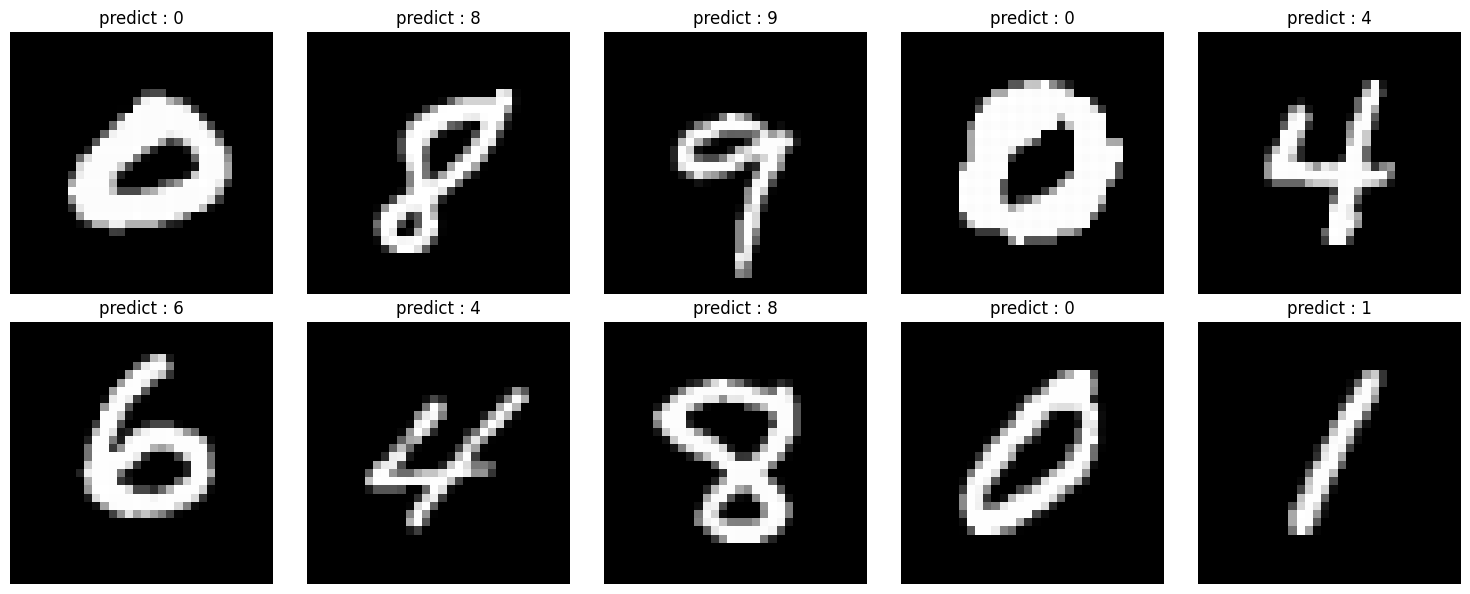

In [40]:
num_example = 10
test_sample = x_test[:10, :]
predict_test_sample = model.forward(test_sample)

# visualize 

imgs = []
for img in test_sample:
    img = img.reshape(32, 32)
    imgs.append(img)

titles = []
for title in predict_test_sample:
    titles.append(np.argmax(title))

# Create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# axes is a 2×5 array — flatten it so we can zip with images & titles
for ax, img, title in zip(axes.flat, imgs, titles):
    ax.imshow(img, cmap='gray')    # or remove cmap= if your images are RGB
    ax.set_title(f"predict : {title}")
    ax.axis('off')                 # turn off axis ticks/labels

plt.tight_layout()
plt.show()